## Outline:

1. Import and read data
2. Visualise data
3. Preprocess data (remove NA) and feature selection
4. Run models (LR, RF, GBR, XGB and TF)
5. Stacking >>> Problems! :(

In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import model_selection, preprocessing
import xgboost as xgb
import datetime

/usr/local/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
macro = pd.read_csv('input/macro.csv')

In [7]:
train_df=pd.merge(macro, train)
train_df.shape

(30471, 391)

In [8]:
train_df.head()

,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,2011-08-20,109.31,14313.7,3.3,354.0,420.7,86.721,15.459,10.1,29.0048,...,9,4,0,13,22,1,0,52,4,5850000
1,2011-08-23,109.31,14313.7,3.3,354.0,420.7,86.721,15.459,10.1,28.9525,...,15,3,0,15,29,1,10,66,14,6000000
2,2011-08-27,109.31,14313.7,3.3,354.0,420.7,86.721,15.459,10.1,28.8082,...,10,3,0,11,27,0,4,67,10,5700000
3,2011-09-01,111.29,14313.7,3.3,353.2,434.4,86.721,15.386,10.1,28.9655,...,11,2,1,4,4,0,0,26,3,13100000
4,2011-09-05,111.29,14313.7,3.3,353.2,434.4,86.721,15.386,10.1,29.4625,...,319,108,17,135,236,2,91,195,14,16331452


In [9]:
test_df=pd.merge(macro, test)
test_df.shape

(7662, 390)

### Data preprocessing

/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


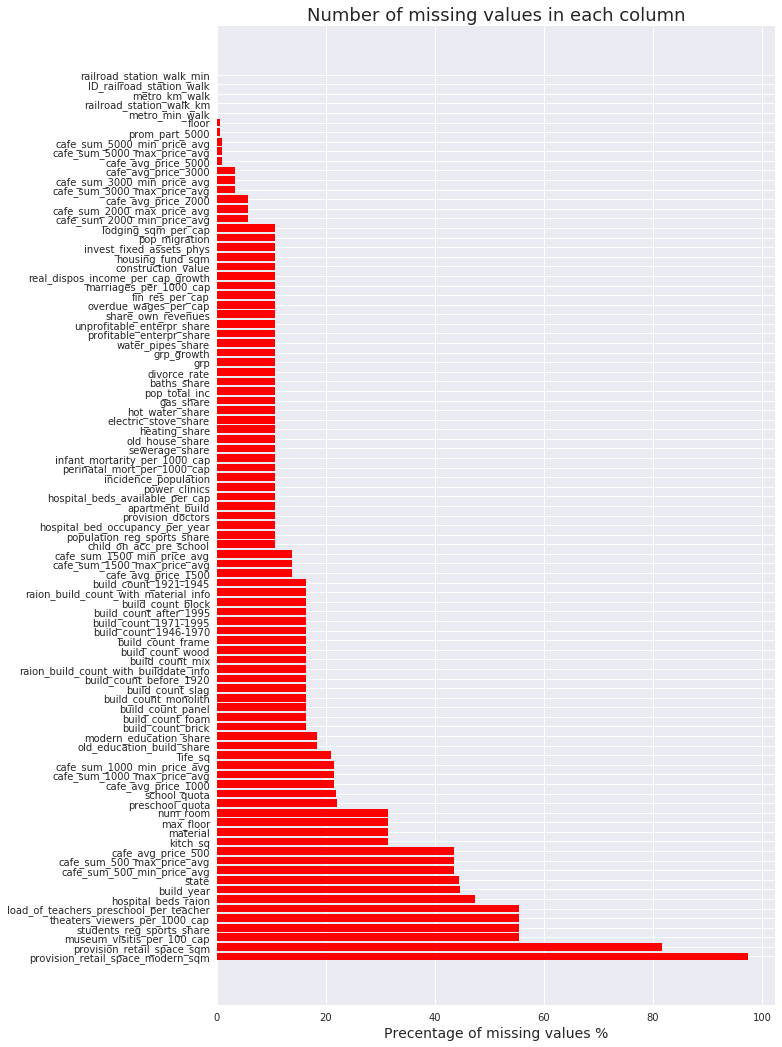

In [10]:
#missing values in train_df

missing = train_df.isnull().sum(0).reset_index()
missing.columns = ['column', 'count']
missing = missing.sort_values(by = 'count', ascending = False).loc[missing['count'] > 0]
missing['percentage'] = missing['count'] / float(train_df.shape[0]) * 100
ind = np.arange(missing.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,18))
rects = ax.barh(ind, missing.percentage.values, color='r')
ax.set_yticks(ind)
ax.set_yticklabels(missing.column.values, rotation='horizontal')
ax.set_xlabel("Precentage of missing values %", fontsize = 14)
ax.set_title("Number of missing values in each column", fontsize = 18)
plt.show()

In [11]:
#drop features with more than 30% missing values from train and test

delete_col = missing.loc[missing['percentage'] >= 30].column.values
train_set = train_df.drop(delete_col, axis=1)
test_set = test_df.drop(delete_col, axis=1)

/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


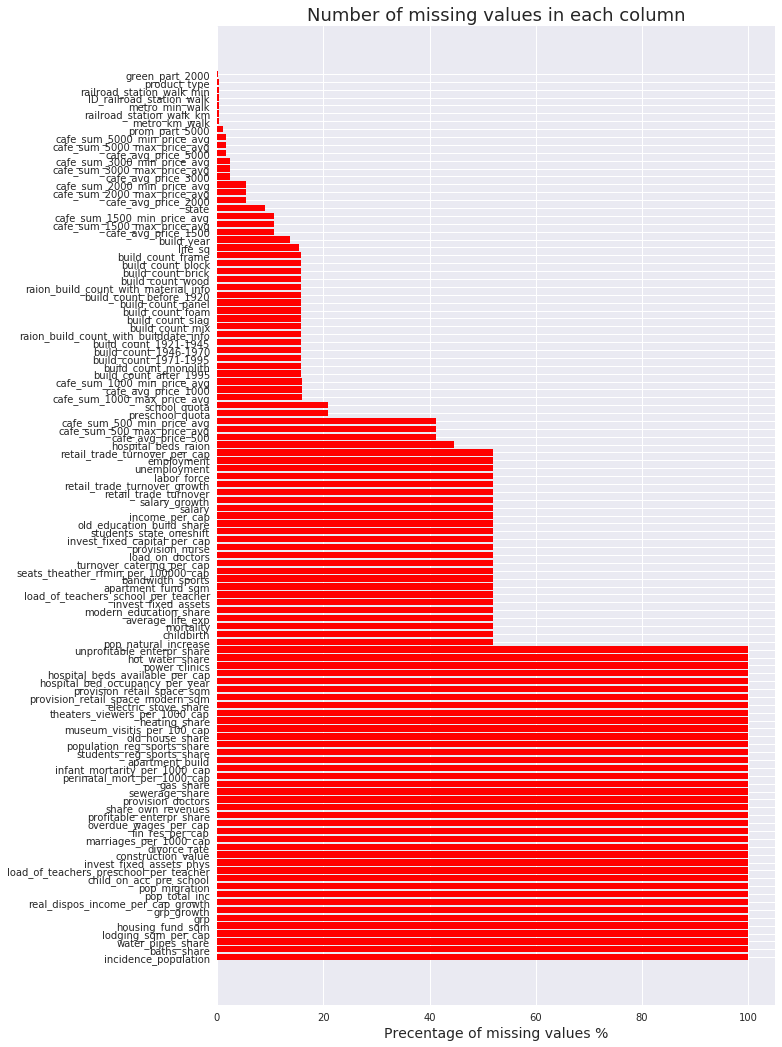

In [12]:
#missing values in test_df

missing = test_df.isnull().sum(0).reset_index()
missing.columns = ['column', 'count']
missing = missing.sort_values(by = 'count', ascending = False).loc[missing['count'] > 0]
missing['percentage'] = missing['count'] / float(test_df.shape[0]) * 100
ind = np.arange(missing.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(10,18))
rects = ax.barh(ind, missing.percentage.values, color='r')
ax.set_yticks(ind)
ax.set_yticklabels(missing.column.values, rotation='horizontal')
ax.set_xlabel("Precentage of missing values %", fontsize = 14)
ax.set_title("Number of missing values in each column", fontsize = 18)
plt.show()

In [13]:
#drop features with more than 30% missing values from train and test

delete_col = missing.loc[missing['percentage'] > 30].column.values
train_set = train_df.drop(delete_col, axis=1)
test_set = test_df.drop(delete_col, axis=1)

In [14]:
train_set.shape

(30471, 322)

In [15]:
test_set.shape

(7662, 321)

In [16]:
for f in train_set.columns:
    if train_set[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_set[f].values)) 
        train_set[f] = lbl.transform(list(train_set[f].values))
dtype_df = train_set.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,175
1,float64,147


In [17]:
#Imputing missing values in train_set

imputer = preprocessing.Imputer(missing_values=np.nan, strategy = 'median', axis =1)

train_data = pd.DataFrame(imputer.fit_transform(train_set))
train_data.columns = train_set.columns
train_data.index = train_set.index

In [ ]:
#Normalize train_data...can't normalize test_data? 

# train_data = pd.DataFrame(preprocessing.normalize(train_data, axis =1, copy=True, return_norm=False))
# train_data.columns = train_set.columns
# train_data.index = train_set.index

In [18]:
y_train = train_data["price_doc"]
x_train = train_data.drop(["id","timestamp", "price_doc"], axis=1)
x_test = test_set.drop(["id","timestamp"], axis=1)

In [19]:
for c in x_train.columns:
    if x_train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[c].values)) 
        x_train[c] = lbl.transform(list(x_train[c].values))
        #x_train.drop(c,axis=1,inplace=True)
        
for c in x_test.columns:
    if x_test[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[c].values)) 
        x_test[c] = lbl.transform(list(x_test[c].values))
        #x_test.drop(c,axis=1,inplace=True)  
        
# lbl = preprocessing.LabelEncoder()
# lbl.fit(y_train)
# y_train = lbl.transform(y_train)

### Train-test split

In [20]:
train_data.shape

(30471, 322)

In [21]:
# Split data into train and test leaving last 100 rows for the final evaluation
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_train.iloc[:-100], y_train.iloc[:-100], test_size=0.2)

In [22]:
print('Database size: {:g} \nTrain set size: {:g} \nTest set size: {:g} \nValidate set size: {:g}'
      .format(len(train_data), len(y_train), len(y_test), len(train_data)-(len(y_train)+len(y_test))))

Database size: 30471 
Train set size: 24296 
Test set size: 6075 
Validate set size: 100


In [23]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
from sklearn import metrics
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold, cross_val_score
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import make_pipeline

import tensorflow as tf
from tensorflow.contrib import learn


/usr/local/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [25]:
# Train & evaluate model performance
def train_and_evaluate(model, X, y):
    model.fit(X, y)
    print('Score on training set: {:g}'.format(model.score(X, y)))
    # k-fold cross validation iterator of 5 folds
    cv = KFold(X.shape[0], 5, shuffle=True)
    scores = cross_val_score(model, X, y, cv=cv)
    print('Score using 5-fold cross-validation: {:g} +/- {:g}'.format(np.mean(scores), np.std(scores)*2))

### Linear Regression

In [26]:
# Ordinary least squares Linear Regression

from sklearn import linear_model
clf_lr = linear_model.LinearRegression()
train_and_evaluate(clf_lr, X_train, y_train.ravel())


Score on training set: 0.400278
Score using 5-fold cross-validation: -0.10951 +/- 2.02461


In [27]:
# Test model prediction on test data
y_pred = clf_lr.predict(X_test)
print('R2 score: {:g}'.format(metrics.r2_score(y_test, y_pred)))
print('Explained variance score: {:g}'.format(metrics.explained_variance_score(y_test, y_pred)))
print('Mean squared error: {:g}'.format(metrics.mean_squared_error(y_test, y_pred)))

R2 score: -13.7382
Explained variance score: -13.7366
Mean squared error: 3.53984e+14


/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


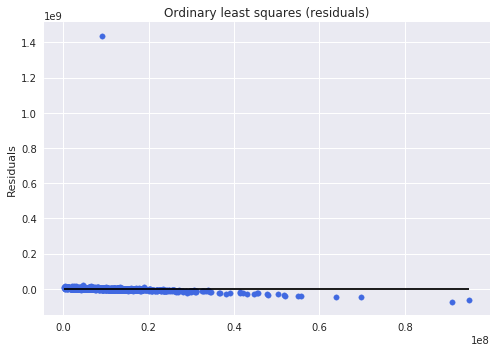

In [28]:
# Residual plot
fig, ax = plt.subplots(figsize=(7,5))
ax.set_title('Ordinary least squares (residuals)')
ax.scatter(y_test, y_pred-y_test, color='royalblue', s=30)
ax.set_ylabel('Residuals')
ax.hlines(0, y_test.min(), y_test.max())
plt.tight_layout()
plt.show()

### SVM using GridSearch

In [29]:
# Support Vector Regression - takes super loooong to run! 
# svr = SVR()
# params = {'C':[0.01, 0.1, 1., 10., 100., 1000.],
#           'kernel':['linear', 'poly', 'rbf'],
#           'epsilon':[0.1, 1.]}

# Grid search with cross-validation for optimal parameters
# grid_obj = GridSearchCV(estimator=svr, param_grid=params, cv=5, n_jobs=-1)
# grid_obj.fit(X_train, y_train)

# Test model prediction on test data
# y_pred = mach.predict(X_test)

# print('R2 score: {:g}'.format(metrics.r2_score(y_test, y_pred)))
# print('Explained variance score: {:g}'.format(metrics.explained_variance_score(y_test, y_pred)))
# print('Mean squared error: {:g}'.format(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
# clf = svm.SVC(kernel='rbf') - takes too long to run! 
# clf.fit(X_train, y_train)

# # Test model prediction on test data
# y_pred = clf.predict(X_test)

# print('R2 score: {:g}'.format(metrics.r2_score(y_test, y_pred)))
# print('Explained variance score: {:g}'.format(metrics.explained_variance_score(y_test, y_pred)))
# print('Mean squared error: {:g}'.format(metrics.mean_squared_error(y_test, y_pred)))

### Random Forest

In [30]:
# RandomForestRegressor

forest = RandomForestRegressor()
train_and_evaluate(forest, X_train, y_train)

Score on training set: 0.940651
Score using 5-fold cross-validation: 0.637096 +/- 0.0768688


In [31]:
# Test model prediction on test data

y_pred = forest.predict(X_test)
print('R2 score: {:g}'.format(metrics.r2_score(y_test, y_pred)))
print('Explained variance score: {:g}'.format(metrics.explained_variance_score(y_test, y_pred)))
print('Mean squared error: {:g}'.format(metrics.mean_squared_error(y_test, y_pred)))

R2 score: 0.673325
Explained variance score: 0.673505
Mean squared error: 7.84614e+12


### Gradient Boosting Regressor

In [32]:
# Gradient Boosting Regressor
clf_gb = GradientBoostingRegressor(loss='lad', max_depth=10, n_estimators=100)
train_and_evaluate(clf_gb, X_train, y_train)

Score on training set: 0.820068
Score using 5-fold cross-validation: 0.64736 +/- 0.0651039


In [33]:
# Test model prediction on test data
y_pred = clf_gb.predict(X_test)
print('R2 score: {:g}'.format(metrics.r2_score(y_test, y_pred)))
print('Explained variance score: {:g}'.format(metrics.explained_variance_score(y_test, y_pred)))
print('Mean squared error: {:g}'.format(metrics.mean_squared_error(y_test, y_pred)))

R2 score: 0.667294
Explained variance score: 0.668553
Mean squared error: 7.991e+12


/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


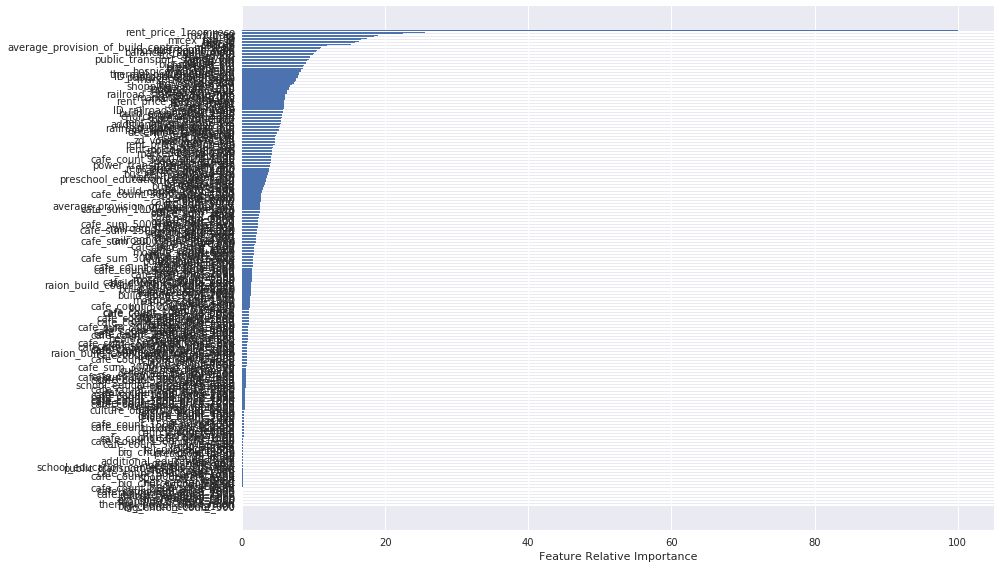

In [34]:
# Feature importance
feature_importance = clf_gb.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig, ax = plt.subplots(figsize=(14,8))
ax.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, train_data.columns[sorted_idx])
ax.set_xlabel('Feature Relative Importance')
plt.tight_layout()
plt.show()

### XGBoost

[0]	train-rmse:8.21126e+06	test-rmse:8.2159e+06
[50]	train-rmse:2.47809e+06	test-rmse:2.92712e+06
[100]	train-rmse:2.11206e+06	test-rmse:2.74406e+06
[150]	train-rmse:1.97485e+06	test-rmse:2.70286e+06
[200]	train-rmse:1.88078e+06	test-rmse:2.68856e+06
[250]	train-rmse:1.80253e+06	test-rmse:2.68012e+06
[300]	train-rmse:1.7306e+06	test-rmse:2.67483e+06
[350]	train-rmse:1.66951e+06	test-rmse:2.67212e+06
R2 score: 0.719638
Explained variance score: 0.71964
Mean squared error: 6.73377e+12


/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


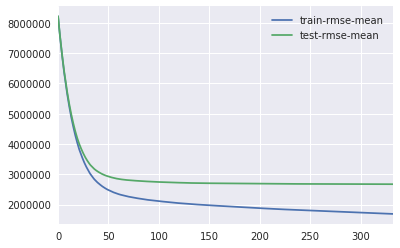

In [35]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test)

xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)
cv_output[['train-rmse-mean', 'test-rmse-mean']].plot()

num_boost_rounds = len(cv_output)
clf_xgb = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)
y_pred = clf_xgb.predict(dtest)

print('R2 score: {:g}'.format(metrics.r2_score(y_test, y_pred)))
print('Explained variance score: {:g}'.format(metrics.explained_variance_score(y_test, y_pred)))
print('Mean squared error: {:g}'.format(metrics.mean_squared_error(y_test, y_pred)))

### TensorFlow

In [36]:
# TensorFlow Regression using DNN
features = learn.infer_real_valued_columns_from_input(X_train)

# Optimizer algorithm
adam = tf.train.AdamOptimizer(learning_rate=0.001)

# Build a multi-layer DNN for regression
model_nn = learn.DNNRegressor(feature_columns=features, hidden_units=[400, 200, 100], 
                              optimizer=adam, activation_fn=tf.nn.relu,
                              )

# Fit and predict
model_nn.fit(X_train, y_train, steps=15000, batch_size=512)
y_pred = model_nn.predict(X_test)

# print('R2 score: {:g}'.format(metrics.r2_score(y_test, y_pred)))
# print('Explained variance score: {:g}'.format(metrics.explained_variance_score(y_test, y_pred)))
# print('Mean squared error: {:g}'.format(metrics.mean_squared_error(y_test, y_pred)))

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'tf_random_seed': None, 'save_summary_steps': 100, '_task_type': None, 'save_checkpoints_secs': 600, 'save_checkpoints_steps': None, '_evaluation_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f535efdb550>, '_environment': 'local', '_is_chief': True, '_num_ps_replicas': 0, 'keep_checkpoint_every_n_hours': 10000, '_task_id': 0, 'keep_checkpoint_max': 5, '_master': '', 'tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and bat

### Stacking Method 1

In [89]:
y_lr = list(clf_lr.predict(X_test))     # Linear 
y_rf = list(forest.predict(X_test))     # Random Forest
y_gb = list(clf_gb.predict(X_test))     # Gradient Boosting

dtest = xgb.DMatrix(X_test)
y_xgb = list(clf_xgb.predict(dtest))    # XGBoost

y_nn = list(model_nn.predict(X_test))   # DNN

stack = pd.DataFrame({'rf':y_rf, 'gb':y_gb, 'xgb':y_xgb,'nn':y_nn, 'true':y_test})

# stack = pd.DataFrame({'lr':y_lr, 'gb':y_gb, 'xgb':y_xgb, 'nn':y_nn, 'true':y_test})
# data = {'rf':y_rf, 'gb':y_gb, 'xgb':y_xgb, 'nn':y_nn, 'true':y_test}

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Summary name dnn/hiddenlayer_0:fraction_of_zero_values is illegal; using

In [90]:
stack.head()

,gb,nn,rf,true,xgb
1715,5.176164e+06,6460289.0,3525000.0,5200000.0,4634399.0
17126,6.717798e+06,6715135.0,6713017.2,6796548.0,5984703.0
28143,7.079944e+06,6605443.0,5577500.0,7300000.0,6499839.5
10037,1.311236e+07,17097614.0,11182783.3,12581315.0,11041008.0
16133,7.970303e+06,5763567.5,7505000.0,7500000.0,7396364.5


In [114]:
X=stack.loc[:, lambda df: ['gb','xgb']]
X.head()

,gb,xgb
1715,5.176164e+06,4634399.0
17126,6.717798e+06,5984703.0
28143,7.079944e+06,6499839.5
10037,1.311236e+07,11041008.0
16133,7.970303e+06,7396364.5


In [115]:
X=stack[['gb','xgb']]
X.head()

,gb,xgb
1715,5.176164e+06,4634399.0
17126,6.717798e+06,5984703.0
28143,7.079944e+06,6499839.5
10037,1.311236e+07,11041008.0
16133,7.970303e+06,7396364.5


In [116]:
# Stacking & Ensembling multiple regressors
stack_type = 'TheilSan'

if stack_type == 'OLS':
    # Ordinary least squares Linear Regression (OLS)
    stacker = linear_model.LinearRegression(fit_intercept=False)
elif stack_type == 'Ridge':
    # Linear least squares with L2 regularization (Ridge)
    stacker = linear_model.Ridge(fit_intercept=False)
elif stack_type == 'TheilSan':
    # Theil-Sen Estimator: robust multivariate regression model
    stacker = linear_model.TheilSenRegressor(fit_intercept=False, n_jobs=-1)

# RF + GBR + XGB + NN
# stacker.fit(X=stack.loc[:, lambda df: ['gb','rf','nn','xgb']], y=stack['true'])
stacker.fit(X=stack[['gb','rf','nn','xgb']], y=stack['true'])

TheilSenRegressor(copy_X=True, fit_intercept=False, max_iter=300,
         max_subpopulation=10000, n_jobs=-1, n_subsamples=None,
         random_state=None, tol=0.001, verbose=False)

In [117]:
# Stacking multiple regressors using DNN
features_blend = learn.infer_real_valued_columns_from_input(stack[['gb','rf','nn','xgb']])

# Optimizer algorithm
adam = tf.train.AdamOptimizer(learning_rate=0.001)

# Build multi-layer DNN for regression
blend_nn = learn.DNNRegressor(feature_columns=features_blend, hidden_units=[20, 10], 
                              optimizer=adam, activation_fn=tf.nn.relu,
                              config=learn.estimators.RunConfig(num_cores=8))
# Fit DNN
# blend_nn.fit(x=stack.loc[:, lambda df: ['gb','rf','nn','xgb']],y=stack['true'], steps=8000, batch_size=256)
blend_nn.fit(x=stack[['gb','rf','nn','xgb']],y=stack['true'], steps=8000, batch_size=256)

INFO:tensorflow:Using config: {'tf_random_seed': None, 'save_summary_steps': 100, '_task_type': None, 'save_checkpoints_secs': 600, 'save_checkpoints_steps': None, '_evaluation_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f534ce0fdd8>, '_environment': 'local', '_is_chief': True, '_num_ps_replicas': 0, 'keep_checkpoint_every_n_hours': 10000, '_task_id': 0, 'keep_checkpoint_max': 5, '_master': '', 'tf_config': intra_op_parallelism_threads: 8
inter_op_parallelism_threads: 8
gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
}
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKComp

DNNRegressor(feature_columns=[_RealValuedColumn(column_name='', dimension=4, default_value=None, dtype=tf.float64, normalizer=None)], optimizer=<tensorflow.python.training.adam.AdamOptimizer object at 0x7f534ce0fe48>, hidden_units=[20, 10], dropout=None)

In [76]:
# Pedict price for new apartments (not seen before)
x_new = x_train.iloc[-100:]  # example
# Scale data
x_new = scaler.transform(x_new)
# True values (actual prices)
true_values = y_train.iloc[-100:].values

In [77]:
# PREDICT: Ordinary least squares Linear Regression
y_new_lr = list(clf_lr.predict(x_new))

# PREDICT: RandomForestRegressor
y_new_rf = list(forest.predict(x_new))

# PREDICT: Gradient Boosting for regression
y_new_gb = list(clf_gb.predict(x_new))

# PREDICT: XGBoost
dtest = xgb.DMatrix(x_new)
y_new_xgb = list(clf_xgb.predict(dtest))

# PREDICT: TensorFlow DNNRegressor
# y_new_nn = np.around(model_nn.predict(x_new), decimals=2)
y_new_nn = list(model_nn.predict(x_new))


Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Summary name dnn/hiddenlayer_0:fraction_of_zero_values is illegal; using

In [78]:
# Relative errors (%) for predictions 

lr_error = (1.-y_new_lr/true_values)*100.
rf_error = (1.-y_new_rf/true_values)*100.
gb_error = (1.-y_new_gb/true_values)*100.
xgb_error = (1.-y_new_xgb/true_values)*100.
nn_error = (1.-y_new_nn/true_values)*100. 

In [79]:
predictions = pd.DataFrame(data={'True Values':y_train.iloc[-100:].values, 
                                 'OLR':y_new_lr, 'OLR Err':lr_error,   # OLR - Ordinary Linear Regression
                                 'RFR':y_new_rf, 'RFR Err':rf_error,   # RFR - Random Forrest regressor
                                 'GBR':y_new_gb, 'GBR Err':gb_error,   # GBR - Gradient Boost regresor
                                 'XGB':y_new_xgb,'XGB Err':xgb_error,  # XGB - XGBoost
                                 'DNN':y_new_nn, 'DNN Err':nn_error})  # DNN - Deep Neural Network

In [80]:
algos_predicted = predictions[['OLR', 'RFR', 'GBR', 'XGB','DNN']]
for col in algos_predicted:
    rms_log = metrics.mean_squared_error(np.log(predictions['True Values']), np.log(algos_predicted[col]))
    print('{:s}: RMSE = {:g}'.format(col, np.sqrt(rms_log)))

OLR: RMSE = 0.766675
RFR: RMSE = 0.794271
GBR: RMSE = 0.79499
XGB: RMSE = 0.80827
DNN: RMSE = 0.809331


In [95]:
#Stacking is using the output of the stacked models (RFR, GBR, XGB, DNN) as input

# Gradient Boosting + XGBoost + DNN
new_stack = pd.DataFrame({'gbr':y_new_gb,'rf':y_new_rf, 'xgb':y_new_xgb, 'nn':y_new_nn, 'true':true_values})

# PREDICT: Stacked regressors (Stack)
y_new_st = stacker.predict(new_stack.loc[:, lambda df: ['rf','gbr', 'xgb', 'nn']])

# Relative errors (%) for predictions
st_error = (1.-y_new_st/true_values)*100.

In [96]:
new_stack.head()

,gbr,nn,rf,true,xgb
0,9.558773e+06,7120524.0,8300000.0,7702570.0,8028340.5
1,1.226388e+07,12114998.0,11628650.5,2000000.0,12450310.0
2,7.700731e+06,11809976.0,7207657.0,4021422.0,7868170.5
3,6.257581e+06,6559548.0,4210000.0,5900000.0,6041736.0
4,5.650842e+06,5680184.0,5278979.7,9250000.0,4883958.0


In [104]:
# PREDICT: Stacked regressors using DNN (Ensemble)

y_new_bl = list(blend_nn.predict(new_stack.loc[:, lambda df: ['rf','gbr', 'xgb', 'nn']]))

#Array works too, because function was passing a generator. Adding a list()/array() made the generator yield all its values at once.
#y_new_bl = array(blend_nn.predict(new_stack.loc[:, lambda df: ['rf','gbr', 'xgb', 'nn']]))

bl_error = (1.-y_new_bl/true_values)*100.

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Summary name dnn/hiddenlayer_0:fraction_of_zero_values is illegal; using

In [105]:
# Averageing best predictions from different regressors
# Extra Trees + Gradient Boosting + AdaBoost
w = [1, 1, 1, 1]  # weights
y_new_agg = np.c_[y_new_gb, y_new_rf, y_new_xgb, y_new_nn]
y_new_avr = np.average(y_new_agg, axis=1, weights=w)
avr_error = (1.-y_new_avr/true_values)*100.

In [109]:
from collections import OrderedDict

predictions = (('True Values',y_train.iloc[-100:].values), 
               ('Average',y_new_avr), ('Average Err',avr_error),
               ('Stack',y_new_st), ('Stack Err',st_error),
               ('Ensamble',y_new_bl), ('Ensamble Err',bl_error))
preds_avr = pd.DataFrame(data=OrderedDict(predictions))

In [110]:
# Root Mean Square Error (RMSE) between the logarithm of the  
# predicted value and the logarithm of the observed sales price
rms_log = metrics.mean_squared_error(np.log(preds_avr['True Values']), np.log(preds_avr['Average']))
print('  Average: RMSE = {:g}'.format(np.sqrt(rms_log)))
rms_log = metrics.mean_squared_error(np.log(preds_avr['True Values']), np.log(preds_avr['Stack']))
print('    Stack: RMSE = {:g}'.format(np.sqrt(rms_log)))
rms_log = metrics.mean_squared_error(np.log(preds_avr['True Values']), np.log(preds_avr['Ensamble']))
print(' Ensamble: RMSE = {:g}'.format(np.sqrt(rms_log)))

  Average: RMSE = 0.79759
    Stack: RMSE = 0.795815
 Ensamble: RMSE = 0.810046


### Stacking Method 2 - not working...

In [56]:
from random import randrange

# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy)) #>>>problem here, but isn't train_data passed in here as dataset???
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores

# Make a prediction with coefficients
def logistic_regression_predict(model, row):
	yhat = model[0]
	for i in range(len(row)-1):
		yhat += model[i + 1] * row[i]
	return 1.0 / (1.0 + exp(-yhat))

# Estimate logistic regression coefficients using stochastic gradient descent
def logistic_regression_model(train, l_rate=0.01, n_epoch=5000):
	coef = [0.0 for i in range(len(train[0]))]
	for epoch in range(n_epoch):
		for row in train:
			yhat = logistic_regression_predict(coef, row)
			error = row[-1] - yhat
			coef[0] = coef[0] + l_rate * error * yhat * (1.0 - yhat)
			for i in range(len(row)-1):
				coef[i + 1] = coef[i + 1] + l_rate * error * yhat * (1.0 - yhat) * row[i]
	return coef

# Make predictions with sub-models and construct a new stacked row
def to_stacked_row(models, predict_list, row):
	stacked_row = list()
	for i in range(len(models)):
		prediction = predict_list[i](models[i], row)
		stacked_row.append(prediction)
	stacked_row.append(row[-1])
	return row[0:len(row)-1] + stacked_row

# Stacked Generalization Algorithm
def stacking(train, test):
	model_list = [forest, clf_gb]
	predict_list = [y_rf, y_gb]
	models = list()
	for i in range(len(model_list)):
		model = model_list[i](train)
		models.append(model)
	stacked_dataset = list()
	for row in train:
		stacked_row = to_stacked_row(models, predict_list, row)
		stacked_dataset.append(stacked_row)
	stacked_model = logistic_regression_model(stacked_dataset)
	predictions = list()
	for row in test:
		stacked_row = to_stacked_row(models, predict_list, row)
		stacked_dataset.append(stacked_row)
		prediction = logistic_regression_predict(stacked_model, stacked_row)
		prediction = round(prediction)
		predictions.append(prediction)
	return predictions

# load and prepare data
dataset = train_data
n_folds = 3
scores = evaluate_algorithm(dataset, stacking, n_folds)

print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

ValueError: empty range for randrange()

In [57]:
train_data.head()

,timestamp,oil_urals,gdp_quart,gdp_quart_growth,cpi,ppi,gdp_deflator,balance_trade,balance_trade_growth,usdrub,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
0,0.0,109.31,14313.7,3.3,354.0,420.7,86.721,15.459,10.1,29.0048,...,9.0,4.0,0.0,13.0,22.0,1.0,0.0,52.0,4.0,5850000.0
1,1.0,109.31,14313.7,3.3,354.0,420.7,86.721,15.459,10.1,28.9525,...,15.0,3.0,0.0,15.0,29.0,1.0,10.0,66.0,14.0,6000000.0
2,2.0,109.31,14313.7,3.3,354.0,420.7,86.721,15.459,10.1,28.8082,...,10.0,3.0,0.0,11.0,27.0,0.0,4.0,67.0,10.0,5700000.0
3,3.0,111.29,14313.7,3.3,353.2,434.4,86.721,15.386,10.1,28.9655,...,11.0,2.0,1.0,4.0,4.0,0.0,0.0,26.0,3.0,13100000.0
4,4.0,111.29,14313.7,3.3,353.2,434.4,86.721,15.386,10.1,29.4625,...,319.0,108.0,17.0,135.0,236.0,2.0,91.0,195.0,14.0,16331452.0


In [ ]:
#https://discussions.udacity.com/t/having-trouble-stacking/248086/17